# Hand-On in Deep Reinforcement Learning in Python


## Requirements

### Deep Learning and Reinforcement Learning Library
- Gym
- PyTorch
- Stable Baselines 3

In [1]:
!pip install swig==4.1.1 > /dev/null 2>&1
!pip install box2d-py==2.3.5 > /dev/null 2>&1
!pip install numpy==1.21.5 > /dev/null 2>&1
!pip install 'gymnasium[box2d]==0.28.1' > /dev/null 2>&1
!pip3 install torch torchvision torchaudio > /dev/null 2>&1

### Visualization Libraries
- Virtualdisplay

Works only on linux and with xvbf installed.

In [2]:
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install xvfbwrapper > /dev/null 2>&1
!pip install 'pyvirtualdisplay==0.2.*'  'PyOpenGL==3.1.*' 'PyOpenGL-accelerate==3.1.*' > /dev/null 2>&1

In [3]:
import pyvirtualdisplay
pyvirtualdisplay.Display(visible=False, size=(1400, 900)).start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

### Gym Basics
Simple example of how to interact with the environment

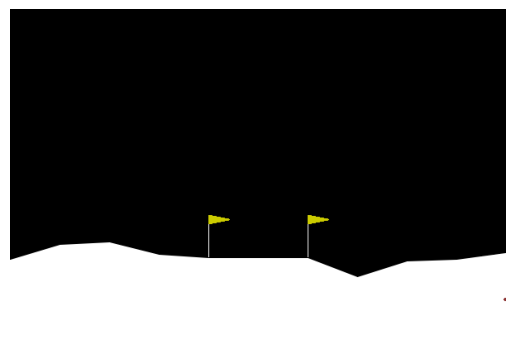

In [4]:
import gymnasium as gym
import copy
### From rendering
from IPython import display
import matplotlib.pyplot as plt
## Create environment
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset() ## When the env is created it should be reset to initialize the state
img = plt.imshow(env.render()) ## Used for rendering purposes
print(env.action_space.sample())
for i in range(100): ## Run for 1000 steps
    env.step(env.action_space.sample()) ## Pick a random action and progress the environment
    img.set_data(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## For the memory

from random import random
from random import sample
from collections import namedtuple, deque
# Plotting
import matplotlib
import matplotlib.pyplot as plt

In [6]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def create_experience(state, action, reward, next_state, done):
    return {
        "state" : state, "action" : action, "reward" : reward, "next_state" : next_state, "done" : done
    }

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(create_experience(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)


    def __len__(self):
        return len(self.memory)


In [8]:
class RenderStrategy:
    def render(self, data):
        pass
    def update(self):
        pass
class OffRenderer(RenderStrategy):
    def render(self, data):
        return

class OnRenderer(RenderStrategy):
    def __init__(self, render_every=1):
        self.img = None
        self.render_every = render_every
        self.render_count = 0
    def render(self, data):
        if self.render_count % self.render_every == 0:
            if self.img is None:
                self.img = plt.imshow(data)
            self.img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    def update(self):
        self.render_count += 1
        self.img = None

In [9]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [10]:
import math
# Exponential decay that decays from start to end. After each call to decay it should reduce the value by decay_rate
class ExponentialDecay:
    def __init__(self, start, end, decay_rate):
        self.start = start
        self.end = end
        self.decay_rate = decay_rate
        self.value = start
        self.initial = start
    def decay(self):
        self.value = max(self.end, self.value * self.decay_rate)

    def __call__(self):
        return self.value

    def reset(self):
        self.value = self.initial

In [11]:
import copy

class DQNAgent:
    def __init__(self, network, memory, batch_size, gamma, learning_rate, epsilon, action_space, copy_target_every=100):
        self.policy_network = network
        self.target_network = copy.deepcopy(network)
        self.policy_network.train()
        self.target_network.train()
        self.memory = memory
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=learning_rate, amsgrad=True)
        self.epsilon = epsilon
        self.copy_target_every = copy_target_every
        self.updates = 0
        self.action_space = action_space
        self.learning = True

    def eval(self):
        self.policy_network.eval()
        self.target_network.eval()
        self.learning = False

    def train(self):
        self.policy_network.train()
        self.target_network.train()
        self.learning = True

    def act(self, state):
        with torch.no_grad():
            return self.policy_network(state).max(0)[1].item()

    def act_epsilon_greedy(self, state):
        if random() > self.epsilon():
            return self.act(state)
        else:
            return self.action_space.sample()

    def record(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size and self.learning:
            self.learn()
            self.updates += 1
            if self.updates % self.copy_target_every == 0:
                self.target_network.load_state_dict(self.policy_network.state_dict())
    def learn(self):
        batch = self.memory.sample(self.batch_size)
        ## Create tensors for the batch
        states = torch.stack([experience["state"] for experience in batch]).to(device)
        actions = torch.tensor([experience["action"] for experience in batch]).to(device)
        rewards = torch.tensor([experience["reward"] for experience in batch]).to(device)
        next_states = torch.stack([experience["next_state"] for experience in batch]).to(device)
        dones = torch.tensor([experience["done"] for experience in batch])
        with torch.no_grad(): ## No backprop here, just for the target (i.e. ground truth)
            next_state_values = self.target_network(next_states).max(1)[0]
        target = rewards + (self.gamma * next_state_values)  # $y_i = r + \gamma \max_{a'} Q(s', a', \theta^-)$
        target[dones] = 0
        predicted = self.policy_network(states).gather(1, actions.unsqueeze(1)).squeeze(1) # $Q(s, a, \theta)$
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicted, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [12]:
## Episode

def run_episode(env, agent, render):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        render.render(env.render()) ## Used for rendering purposes
        action = agent.act_epsilon_greedy(torch.tensor(state, dtype=torch.float32, device=device))
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.record(torch.tensor(state, dtype=torch.float32, device=device), action, reward, torch.tensor(next_state, dtype=torch.float32, device=device), done)
        state = next_state
        done = terminated or truncated
        total_reward += reward
    return total_reward


In [15]:
def train(env, agent, episodes, render):
    rewards = []
    for episode in range(episodes):
        display.clear_output(wait=True)
        reward = run_episode(env, agent, render)
        agent.epsilon.decay()
        rewards.append(reward)
        print(f"Episode: {episode}, Reward: {reward}, Epsilon {agent.epsilon()}")
        ## Plot the rewards
        plt.clf()
        plt.title(f'Training...  Episode: {episode}')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(rewards)
        display.display(plt.gcf())
        render.update()
        display.clear_output(wait=True)
    return rewards

Episode: 2, Reward: -99.77244993083318, Epsilon 0.8732691


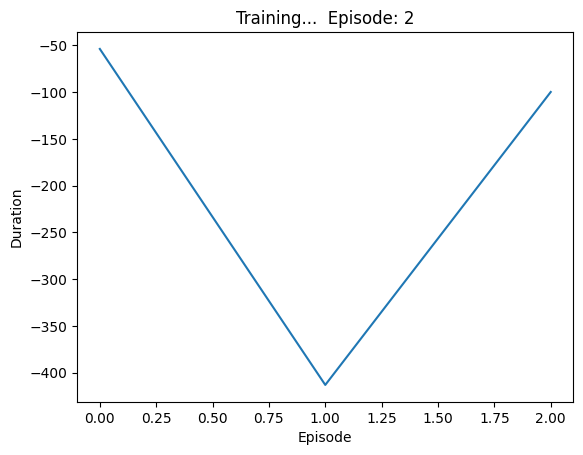

In [ ]:
# Create the environment
torch.manual_seed(42)
from random import seed
seed(42)
env = gym.make('LunarLander-v2', render_mode="rgb_array")
## Initialize the networks
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n
hidden_size = 256
network = DQN(n_observations, n_actions, hidden_size).to(device)
memory = ReplayMemory(10000)
batch_size = 128
gamma = 0.99
learning_rate = 1e-4
epsilon = ExponentialDecay(0.9, 0.05, 0.99)
agent = DQNAgent(network, memory, batch_size, gamma, learning_rate, epsilon, env.action_space, 1000)

train(env, agent, 1000, render=OnRenderer(100))
"Trained..."